In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from scipy import ndimage
from sklearn.datasets import make_gaussian_quantiles, make_moons, make_circles, make_blobs
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import modules.complexity_estimator as ce
import modules.util as u
from modules.oracle import Oracle
from nd_boundary_plot.plots import nd_boundary_plot


################################################################################################33
#scatter plot of a dataset helper
#
def plot_ds(grid_size, loc, X, y, xx, yy, title, seeds=None, colspan=1, rowspan=1):

    ax = plt.subplot2grid(grid_size, loc, rowspan=rowspan, colspan=colspan)

    ax.set_title(title)
    # Plot also the training points
    ax.scatter(X[:, 0],X[:, 1], c=y)
    # and seeds
    if seeds is not None:
        ax.scatter(X[seeds, 0], X[seeds, 1],
                   alpha=1.0, facecolors='magenta')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

#perform active learning
#
def active(classifiers, datasets, experiments, quota=25, plot_every_n=5):
    # USE THIS INSTEAD OF YTGT WHICH WE PRETEND TO NOT KNOW

    for dsix, ((X_src, y_src), (X_tgt, y_tgt)) in enumerate(datasets):
        u_tgt = [None] * len(X_tgt)
        est_src = ce.ComplexityEstimator(X_src, y_src)
        est_tgt = ce.ComplexityEstimator(X_tgt, y_tgt)
        # declare Dataset instance, X is the feature, y is the label (None if unlabeled)
        X = np.vstack((X_src, X_tgt))

        h = .05  # step size in the mesh
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        figure = plt.figure(figsize=(27, 13))

        grid_size = (1+len(classifiers), 6)
        for n, classifier in enumerate(classifiers):
            model = classifier
            oracle = Oracle(X_tgt, y_tgt)
            # plot src
            plot_ds(grid_size, (0, 0), X_src, y_src, xx, yy, 'Src', est_src.seeds)
            ax = plt.subplot2grid(grid_size, (0,1), colspan=2)
            ax.set_title('Src complexity')
            Ks, Es = est_src.get_k_complexity()
            ax.plot(Ks, Es)
            #plt tgt
            plot_ds(grid_size, (0, 3), X_tgt, y_tgt, xx, yy, 'Tgt', est_tgt.seeds)
            ax = plt.subplot2grid(grid_size, (0,4), colspan=2)
            Ks, Es = est_tgt.get_k_complexity()
            ax.set_title('Tgt complexity')
            ax.plot(Ks, Es)
            w = 0
            X_known = X_src.tolist()
            y_known = y_src.tolist()
            for i in range(quota):  # loop through the number of queries
                loc, y_loc = oracle.random_query()  # let the specified QueryStrategy suggest a data to query
                u_tgt[loc] = y_loc
                X_known.append(X_tgt[loc])
                y_known.append(y_tgt[loc])
                if i == 0 or i % plot_every_n == 0 or i == quota - 1:
                    model.fit(X_known, y_known)  # train model with newly-updated Dataset
                    score = model.score(X_tgt, y_tgt)
                    ax = plt.subplot2grid(grid_size, (n + 1, w))
                    nd_boundary_plot(X_tgt, model, (x_min, x_max, y_min, y_max), ax)
                    if i == 0:
                        ax.set_ylabel(u.classname(model))
                    if n == 0:
                        ax.set_title('# queries=' + str(i))
                    ax.set_xlabel('Accuracy='+('%.2f' % score).lstrip('0'))
                    w += 1

        figure.suptitle(experiments[dsix])
        figure.tight_layout()
        fname = './vis/' + str(experiments[dsix]) + '.png'
        figure.savefig(filename=fname)
    plt.show()

In [4]:
def load_mnist_src_data():
    mnist = pd.read_csv('./data/mnist/train_src.csv')
    y = mnist.as_matrix(columns=['label'])
    X = mnist.drop('label', axis=1).as_matrix()
    
    rows = 4 
    columns = 5
    indx = 1
    for image in X[:rows*columns]:
        img = np.reshape(image, [28, 28])
        plt.subplot(rows, columns, indx)
        plt.axis('off')
        plt.imshow(img)
        indx += 1
    plt.show()
    print(image.shape)
    print(img.shape)
    print(X.shape)

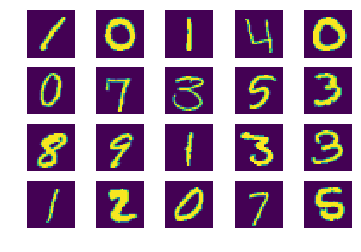

(784,)
(28, 28)
(42000, 784)


In [5]:
load_mnist_src_data()

In [67]:
def load_mnist_trgt_data():
    mnist_trgt = pd.read_csv('./data/mnist_rotated/train_trgt.csv')
    y = mnist_trgt.as_matrix(columns=['label'])
    X_norm = mnist_trgt.drop('label', axis=1).as_matrix()
    
    rows = 42000
    columns = 784
    indx = 1
    X = []
    for image in X_norm[:rows*columns]:
        img = np.reshape(image, [28, 28])
        rotated = ndimage.rotate(img, 90)
        X.append(rotated)
        indx += 1
    X = np.array(X).reshape(rows, -1)
    print(image.shape)
    print(img.shape)
    print(X.shape)
    
    mnist_rotated = pd.DataFrame(X)
    # mnist_rotated.to_csv('minst_rotated.csv', index=False, header=False)
    
    return X

(42000, 784)


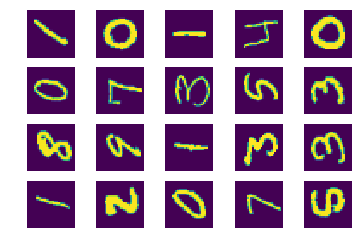

In [68]:
load_mnist_trgt_data()

In [70]:
clfs = [SVC(), LinearSVC(), AdaBoostClassifier(), GaussianNB()]
datasets = []
experiments = []

datasets.append((load_mnist_data(), load_mnist_rotated_data()))
experiments.append('MNIST_vs_RevMNIST')
# datasets.append((u.hastie(500), make_gaussian_quantiles(n_samples=500, n_features=10, n_classes=2)))
# experiments.append('hastie_10_2_vs_gauss_quant_10_2')
# datasets.append((make_moons(), make_circles()))
# experiments.append('moons')
# datasets.append((make_blobs(), make_blobs()))
# experiments.append('blobs')

active(classifiers=clfs, datasets=datasets, experiments=experiments)

NameError: name 'load_mnist_data' is not defined